# Expedia Dataset

In [1]:
import csv
import pandas as pd
import lightgbm
import numpy as np
# import dask to solve memory error
# Arrays implement the Numpy API
import dask.array as da
# Dataframes implement the Pandas API
import dask.dataframe as dd

# 1 Import Data

In [2]:
with open('train.csv', newline='') as f:
  reader = csv.reader(f)
  row1 = next(reader) 
print(row1)

['srch_id', 'date_time', 'site_id', 'visitor_location_country_id', 'visitor_hist_starrating', 'visitor_hist_adr_usd', 'prop_country_id', 'prop_id', 'prop_starrating', 'prop_review_score', 'prop_brand_bool', 'prop_location_score1', 'prop_location_score2', 'prop_log_historical_price', 'position', 'price_usd', 'promotion_flag', 'srch_destination_id', 'srch_length_of_stay', 'srch_booking_window', 'srch_adults_count', 'srch_children_count', 'srch_room_count', 'srch_saturday_night_bool', 'srch_query_affinity_score', 'orig_destination_distance', 'random_bool', 'comp1_rate', 'comp1_inv', 'comp1_rate_percent_diff', 'comp2_rate', 'comp2_inv', 'comp2_rate_percent_diff', 'comp3_rate', 'comp3_inv', 'comp3_rate_percent_diff', 'comp4_rate', 'comp4_inv', 'comp4_rate_percent_diff', 'comp5_rate', 'comp5_inv', 'comp5_rate_percent_diff', 'comp6_rate', 'comp6_inv', 'comp6_rate_percent_diff', 'comp7_rate', 'comp7_inv', 'comp7_rate_percent_diff', 'comp8_rate', 'comp8_inv', 'comp8_rate_percent_diff', 'click_b

In [3]:
row1.remove('position')
row1.remove('gross_bookings_usd')
print(row1)

['srch_id', 'date_time', 'site_id', 'visitor_location_country_id', 'visitor_hist_starrating', 'visitor_hist_adr_usd', 'prop_country_id', 'prop_id', 'prop_starrating', 'prop_review_score', 'prop_brand_bool', 'prop_location_score1', 'prop_location_score2', 'prop_log_historical_price', 'price_usd', 'promotion_flag', 'srch_destination_id', 'srch_length_of_stay', 'srch_booking_window', 'srch_adults_count', 'srch_children_count', 'srch_room_count', 'srch_saturday_night_bool', 'srch_query_affinity_score', 'orig_destination_distance', 'random_bool', 'comp1_rate', 'comp1_inv', 'comp1_rate_percent_diff', 'comp2_rate', 'comp2_inv', 'comp2_rate_percent_diff', 'comp3_rate', 'comp3_inv', 'comp3_rate_percent_diff', 'comp4_rate', 'comp4_inv', 'comp4_rate_percent_diff', 'comp5_rate', 'comp5_inv', 'comp5_rate_percent_diff', 'comp6_rate', 'comp6_inv', 'comp6_rate_percent_diff', 'comp7_rate', 'comp7_inv', 'comp7_rate_percent_diff', 'comp8_rate', 'comp8_inv', 'comp8_rate_percent_diff', 'click_bool', 'booki

In [4]:
#delete mismatched columns
df = pd.read_csv("train.csv", usecols = row1)

In [5]:
#create a new data set store total number of click and booking for one search
df_query = df.loc(axis = 1)['srch_id','click_bool', 'booking_bool' ]
df_query['click_bool'] = df_query['click_bool'].astype(int)
df_query['booking_bool'] = df_query['booking_bool'].astype(int)
df_query = df_query.groupby(['srch_id']).sum()
df_query

,click_bool,booking_bool
srch_id,,
1,1,1
4,1,0
6,1,1
8,1,1
11,1,0
...,...,...
665568,1,1
665570,1,0
665572,1,0


In [6]:
#number of search with no click
df_query.astype(bool).sum(axis=0)
#all queries has at least one click --> all queries are usefull

click_bool      399344
booking_bool    276593
dtype: int64

In [7]:
df_query.describe()

,click_bool,booking_bool
count,399344.000000,399344.000000
mean,1.111002,0.692618
std,0.569294,0.461409
min,1.000000,0.000000
25%,1.000000,0.000000
50%,1.000000,1.000000
75%,1.000000,1.000000
max,30.000000,1.000000


In [8]:
pd.set_option("display.max.columns", None)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9917530 entries, 0 to 9917529
Data columns (total 52 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   srch_id                      int64  
 1   date_time                    object 
 2   site_id                      int64  
 3   visitor_location_country_id  int64  
 4   visitor_hist_starrating      float64
 5   visitor_hist_adr_usd         float64
 6   prop_country_id              int64  
 7   prop_id                      int64  
 8   prop_starrating              int64  
 9   prop_review_score            float64
 10  prop_brand_bool              int64  
 11  prop_location_score1         float64
 12  prop_location_score2         float64
 13  prop_log_historical_price    float64
 14  price_usd                    float64
 15  promotion_flag               int64  
 16  srch_destination_id          int64  
 17  srch_length_of_stay          int64  
 18  srch_booking_window          int64  
 19  

In [9]:
df.describe()

,srch_id,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score1,prop_location_score2,prop_log_historical_price,price_usd,promotion_flag,srch_destination_id,srch_length_of_stay,srch_booking_window,srch_adults_count,srch_children_count,srch_room_count,srch_saturday_night_bool,srch_query_affinity_score,orig_destination_distance,random_bool,comp1_rate,comp1_inv,comp1_rate_percent_diff,comp2_rate,comp2_inv,comp2_rate_percent_diff,comp3_rate,comp3_inv,comp3_rate_percent_diff,comp4_rate,comp4_inv,comp4_rate_percent_diff,comp5_rate,comp5_inv,comp5_rate_percent_diff,comp6_rate,comp6_inv,comp6_rate_percent_diff,comp7_rate,comp7_inv,comp7_rate_percent_diff,comp8_rate,comp8_inv,comp8_rate_percent_diff,click_bool,booking_bool
count,9.917530e+06,9.917530e+06,9.917530e+06,505297.000000,507612.000000,9.917530e+06,9.917530e+06,9.917530e+06,9.902900e+06,9.917530e+06,9.917530e+06,7.739150e+06,9.917530e+06,9.917530e+06,9.917530e+06,9.917530e+06,9.917530e+06,9.917530e+06,9.917530e+06,9.917530e+06,9.917530e+06,9.917530e+06,635564.000000,6.701069e+06,9.917530e+06,235806.000000,254433.000000,184907.00000,4.040633e+06,4.251538e+06,1.109847e+06,3.059273e+06,3.292221e+06,944007.000000,620099.000000,692471.000000,2.642130e+05,4.444294e+06,4.720833e+06,1.681006e+06,482487.000000,524145.000000,1.933120e+05,631077.000000,713175.000000,277838.000000,3.819043e+06,3.960388e+06,1.225707e+06,9.917530e+06,9.917530e+06
mean,3.329138e+05,9.966175e+00,1.752954e+02,3.374634,176.588512,1.739055e+02,7.008015e+04,3.181534e+00,3.777702e+00,6.343042e-01,2.875978e+00,1.304190e-01,4.316834e+00,2.417825e+02,2.157616e-01,1.405615e+04,2.390011e+00,3.762379e+01,1.972597e+00,3.487331e-01,1.110800e+00,5.002563e-01,-24.302829,1.307018e+03,2.964097e-01,0.478809,0.030197,244.94037,4.463162e-02,3.956545e-02,2.008163e+01,1.756103e-02,5.745058e-02,26.979212,-0.016810,0.095923,1.557236e+02,2.272509e-02,5.185907e-02,2.838247e+01,0.128975,0.075651,2.301390e+01,0.147061,0.082259,20.141888,-6.072490e-02,9.889435e-03,2.321000e+01,4.473614e-02,2.788930e-02
std,1.922876e+05,7.657325e+00,6.590955e+01,0.692218,108.434842,6.834768e+01,4.061177e+04,1.050191e+00,1.050806e+00,4.816248e-01,1.532092e+00,1.595145e-01,1.836241e+00,1.434181e+04,4.113497e-01,8.115132e+03,2.066758e+00,5.210799e+01,8.590720e-01,7.297288e-01,4.241494e-01,5.000000e-01,15.808004,2.030283e+03,4.566739e-01,0.641991,0.227349,1159.05506,4.481685e-01,2.344546e-01,1.455845e+03,4.578021e-01,2.946643e-01,1023.385701,0.577023,0.336243,5.060417e+03,5.213494e-01,2.682153e-01,1.190736e+03,0.560217,0.302058,2.560429e+03,0.578748,0.316165,136.217976,4.692456e-01,2.031648e-01,9.462088e+02,2.067240e-01,1.646557e-01
min,1.000000e+00,1.000000e+00,1.000000e+00,1.000000,0.000000,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,-326.567500,1.000000e-02,0.000000e+00,-1.000000,-1.000000,2.00000,-1.000000e+00,-1.000000e+00,2.000000e+00,-1.000000e+00,-1.000000e+00,2.000000,-1.000000,-1.000000,2.000000e+00,-1.000000e+00,-1.000000e+00,2.000000e+00,-1.000000,-1.000000,2.000000e+00,-1.000000,-1.000000,2.000000,-1.000000e+00,-1.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00
25%,1.665160e+05,5.000000e+00,1.000000e+02,2.920000,110.330000,1.000000e+02,3.501000e+04,3.000000e+00,3.500000e+00,0.000000e+00,1.790000e+00,1.900000e-02,4.440000e+00,8.500000e+01,0.000000e+00,7.100000e+03,1.000000e+00,4.000000e+00,2.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,-31.085100,1.411200e+02,0.000000e+00,0.000000,0.000000,7.00000,0.000000e+00,0.000000e+00,7.000000e+00,0.000000e+00,0.000000e+00,7.000000,0.000000,0.000000,7.000000e+00,0.000000e+00,0.000000e+00,7.000000e+00,0.000000,0.000000,6.000000e+00,0.000000,0.000000,7.000000,0.000000e+00,0.000000e+00,7.000000e+00,0.000000e+00,0.

In [10]:
pd.set_option("display.max.rows", None)
df.head(10)

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score1,prop_location_score2,prop_log_historical_price,price_usd,promotion_flag,srch_destination_id,srch_length_of_stay,srch_booking_window,srch_adults_count,srch_children_count,srch_room_count,srch_saturday_night_bool,srch_query_affinity_score,orig_destination_distance,random_bool,comp1_rate,comp1_inv,comp1_rate_percent_diff,comp2_rate,comp2_inv,comp2_rate_percent_diff,comp3_rate,comp3_inv,comp3_rate_percent_diff,comp4_rate,comp4_inv,comp4_rate_percent_diff,comp5_rate,comp5_inv,comp5_rate_percent_diff,comp6_rate,comp6_inv,comp6_rate_percent_diff,comp7_rate,comp7_inv,comp7_rate_percent_diff,comp8_rate,comp8_inv,comp8_rate_percent_diff,click_bool,booking_bool
0,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,893,3,3.5,1,2.83,0.0438,4.95,104.77,0,23246,1,0,4,0,1,1,NaN,NaN,1,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,0
1,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,10404,4,4.0,1,2.20,0.0149,5.03,170.74,0,23246,1,0,4,0,1,1,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,0
2,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,21315,3,4.5,1,2.20,0.0245,4.92,179.80,0,23246,1,0,4,0,1,1,NaN,NaN,1,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,0
3,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,27348,2,4.0,1,2.83,0.0125,4.39,602.77,0,23246,1,0,4,0,1,1,NaN,NaN,1,NaN,NaN,NaN,-1.0,0.0,5.0,-1.0,0.0,5.0,NaN,NaN,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,0.0,5.0,0,0
4,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,29604,4,3.5,1,2.64,0.1241,4.93,143.58,0,23246,1,0,4,0,1,1,NaN,NaN,1,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,0
5,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,30184,4,4.5,1,2.77,0.1302,5.20,195.32,0,23246,1,0,4,0,1,1,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,7.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,7.0,0,0
6,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,44147,3,3.5,1,2.20,0.0356,4.81,129.35,0,23246,1,0,4,0,1,1,NaN,NaN,1,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,0
7,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,50984,2,0.0,0,1.61,NaN,4.14,85.37,0,23246,1,0,4,0,1,1,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
8,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,53341,4,4.0,1,2.56,0.1238,5.18,150.05,0,23246,1,0,4,0,1,1,NaN,NaN,1,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,6.0,0,0
9,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,56880,4,4.0,1,2.83,0.1028,5.15,280.69,0,23246,1,0,4,0,1,1,NaN,NaN,1,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,0


In [11]:
na = df.isna().sum()
print(na)

srch_id                              0
date_time                            0
site_id                              0
visitor_location_country_id          0
visitor_hist_starrating        9412233
visitor_hist_adr_usd           9409918
prop_country_id                      0
prop_id                              0
prop_starrating                      0
prop_review_score                14630
prop_brand_bool                      0
prop_location_score1                 0
prop_location_score2           2178380
prop_log_historical_price            0
price_usd                            0
promotion_flag                       0
srch_destination_id                  0
srch_length_of_stay                  0
srch_booking_window                  0
srch_adults_count                    0
srch_children_count                  0
srch_room_count                      0
srch_saturday_night_bool             0
srch_query_affinity_score      9281966
orig_destination_distance      3216461
random_bool              

missing values needed to be imputed:

hotel description:
prop_review_score,
prop_location_score2,
srch_query_affinity_score

orig_destination_distance

# 2 Data Preprocessing

## down sampling negative instances
(only 5% click --> imbalanced data)

In [12]:
#indices of each class's observations
i_click = np.where(df['click_bool'] == 1)[0]
i_no_click = np.where(df['click_bool'] == 0)[0]

#number of observations in each class
n_click = len(i_click)
n_no_click = len(i_no_click)
print(n_click/(n_click + n_no_click))

#randomly delete 80% of no_click hotels
df = df.drop(df[df['click_bool'] == 0].sample(frac = .8).index)

df.head(10)

0.044736138937820205


,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score1,prop_location_score2,prop_log_historical_price,price_usd,promotion_flag,srch_destination_id,srch_length_of_stay,srch_booking_window,srch_adults_count,srch_children_count,srch_room_count,srch_saturday_night_bool,srch_query_affinity_score,orig_destination_distance,random_bool,comp1_rate,comp1_inv,comp1_rate_percent_diff,comp2_rate,comp2_inv,comp2_rate_percent_diff,comp3_rate,comp3_inv,comp3_rate_percent_diff,comp4_rate,comp4_inv,comp4_rate_percent_diff,comp5_rate,comp5_inv,comp5_rate_percent_diff,comp6_rate,comp6_inv,comp6_rate_percent_diff,comp7_rate,comp7_inv,comp7_rate_percent_diff,comp8_rate,comp8_inv,comp8_rate_percent_diff,click_bool,booking_bool
4,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,29604,4,3.5,1,2.64,0.1241,4.93,143.58,0,23246,1,0,4,0,1,1,NaN,NaN,1,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,0
5,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,30184,4,4.5,1,2.77,0.1302,5.20,195.32,0,23246,1,0,4,0,1,1,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,7.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,7.0,0,0
7,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,50984,2,0.0,0,1.61,NaN,4.14,85.37,0,23246,1,0,4,0,1,1,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
12,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,68914,2,3.0,1,2.20,0.0206,4.44,100.89,0,23246,1,0,4,0,1,1,NaN,NaN,1,NaN,NaN,NaN,0.0,0.0,11.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,11.0,1,1
18,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,88218,4,3.5,1,2.77,0.1266,4.98,115.12,0,23246,1,0,4,0,1,1,NaN,NaN,1,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,0
20,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,95166,3,4.0,1,2.71,0.0359,4.71,122.88,0,23246,1,0,4,0,1,1,NaN,NaN,1,NaN,NaN,NaN,0.0,0.0,12.0,0.0,0.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,0
30,4,2012-12-31 08:59:22,5,219,NaN,NaN,219,11826,5,4.5,1,3.22,0.1924,6.10,373.00,1,12588,2,46,1,0,1,1,NaN,238.33,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
31,4,2012-12-31 08:59:22,5,219,NaN,NaN,219,22824,3,4.0,0,3.26,0.3729,5.74,329.00,0,12588,2,46,1,0,1,1,NaN,238.29,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
33,4,2012-12-31 08:59:22,5,219,NaN,NaN,219,39993,4,4.0,1,3.09,0.1692,5.69,365.00,0,12588,2,46,1,0,1,1,NaN,237.94,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
34,4,2012-12-31 08:59:22,5,219,NaN,NaN,219,46162,4,4.5,0,3.26,0.3582,5.73,331.00,1,12588,2,46,1,0,1,1,NaN,238.32,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0


In [13]:
#indices of each class's observations
i_click = np.where(df['click_bool'] == 1)[0]
i_no_click = np.where(df['click_bool'] == 0)[0]

#number of observations in each class
n_click = len(i_click)
n_no_click = len(i_no_click)
print(n_click/(n_click + n_no_click))

0.18972958086659333


## data imputation

(1) for hotel description

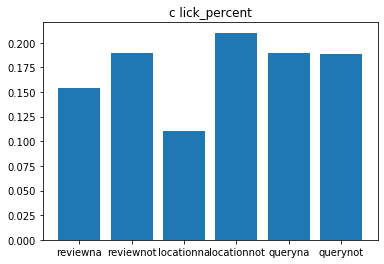

In [14]:
import matplotlib.pyplot as plt
per_prop_review_score_na = len(df[(df['prop_review_score'].isna()) & (df['click_bool'] == 1)])/(df['prop_review_score'].isna().sum())
per_prop_review_score_notna = len(df[(df['prop_review_score'].notna()) & (df['click_bool'] == 1)])/(df['prop_review_score'].notna().sum())
per_prop_location_score2_na = len(df[(df['prop_location_score2'].isna()) & (df['click_bool'] == 1)])/(df['prop_location_score2'].isna().sum())
per_prop_location_score2_notna = len(df[(df['prop_location_score2'].notna()) & (df['click_bool'] == 1)])/(df['prop_location_score2'].notna().sum())
per_srch_query_affinity_score_na = len(df[(df['srch_query_affinity_score'].isna()) & (df['click_bool'] == 1)])/(df['srch_query_affinity_score'].isna().sum())
per_srch_query_affinity_score_notna = len(df[(df['srch_query_affinity_score'].notna()) & (df['click_bool'] == 1)])/(df['srch_query_affinity_score'].notna().sum())

names = ['reviewna', 'reviewnot', 'locationna','locationnot','queryna', 'querynot']
values = [per_prop_review_score_na,per_prop_review_score_notna, per_prop_location_score2_na, per_prop_location_score2_notna, per_srch_query_affinity_score_na, per_srch_query_affinity_score_notna]
plt.bar(names, values)
plt.title('c lick_percent')
plt.show()

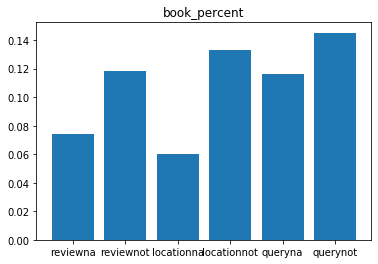

In [15]:
per_prop_review_score_na = len(df[(df['prop_review_score'].isna()) & (df['booking_bool'] == 1)])/(df['prop_review_score'].isna().sum())
per_prop_review_score_notna = len(df[(df['prop_review_score'].notna()) & (df['booking_bool'] == 1)])/(df['prop_review_score'].notna().sum())
per_prop_location_score2_na = len(df[(df['prop_location_score2'].isna()) & (df['booking_bool'] == 1)])/(df['prop_location_score2'].isna().sum())
per_prop_location_score2_notna = len(df[(df['prop_location_score2'].notna()) & (df['booking_bool'] == 1)])/(df['prop_location_score2'].notna().sum())
per_srch_query_affinity_score_na = len(df[(df['srch_query_affinity_score'].isna()) & (df['booking_bool'] == 1)])/(df['srch_query_affinity_score'].isna().sum())
per_srch_query_affinity_score_notna = len(df[(df['srch_query_affinity_score'].notna()) & (df['booking_bool'] == 1)])/(df['srch_query_affinity_score'].notna().sum())

names = ['reviewna', 'reviewnot', 'locationna','locationnot','queryna', 'querynot']
values = [per_prop_review_score_na,per_prop_review_score_notna, per_prop_location_score2_na, per_prop_location_score2_notna, per_srch_query_affinity_score_na, per_srch_query_affinity_score_notna]
plt.bar(names, values)
plt.title('book_percent')
plt.show()

From chart above, hotels with missing value of hotel description are less like to be clicked/booked

impute orig_destinatin_distance 

## subsampling

In [16]:
# df_sample = df[(df['srch_id']%10 == 0) | (df['srch_id']%10 == 1)]
df_sample = df
df_sample.head()

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score1,prop_location_score2,prop_log_historical_price,price_usd,promotion_flag,srch_destination_id,srch_length_of_stay,srch_booking_window,srch_adults_count,srch_children_count,srch_room_count,srch_saturday_night_bool,srch_query_affinity_score,orig_destination_distance,random_bool,comp1_rate,comp1_inv,comp1_rate_percent_diff,comp2_rate,comp2_inv,comp2_rate_percent_diff,comp3_rate,comp3_inv,comp3_rate_percent_diff,comp4_rate,comp4_inv,comp4_rate_percent_diff,comp5_rate,comp5_inv,comp5_rate_percent_diff,comp6_rate,comp6_inv,comp6_rate_percent_diff,comp7_rate,comp7_inv,comp7_rate_percent_diff,comp8_rate,comp8_inv,comp8_rate_percent_diff,click_bool,booking_bool
4,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,29604,4,3.5,1,2.64,0.1241,4.93,143.58,0,23246,1,0,4,0,1,1,NaN,NaN,1,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,0
5,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,30184,4,4.5,1,2.77,0.1302,5.20,195.32,0,23246,1,0,4,0,1,1,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,7.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,7.0,0,0
7,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,50984,2,0.0,0,1.61,NaN,4.14,85.37,0,23246,1,0,4,0,1,1,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
12,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,68914,2,3.0,1,2.20,0.0206,4.44,100.89,0,23246,1,0,4,0,1,1,NaN,NaN,1,NaN,NaN,NaN,0.0,0.0,11.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,11.0,1,1
18,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,88218,4,3.5,1,2.77,0.1266,4.98,115.12,0,23246,1,0,4,0,1,1,NaN,NaN,1,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,0


In [17]:
df_sample.head()

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score1,prop_location_score2,prop_log_historical_price,price_usd,promotion_flag,srch_destination_id,srch_length_of_stay,srch_booking_window,srch_adults_count,srch_children_count,srch_room_count,srch_saturday_night_bool,srch_query_affinity_score,orig_destination_distance,random_bool,comp1_rate,comp1_inv,comp1_rate_percent_diff,comp2_rate,comp2_inv,comp2_rate_percent_diff,comp3_rate,comp3_inv,comp3_rate_percent_diff,comp4_rate,comp4_inv,comp4_rate_percent_diff,comp5_rate,comp5_inv,comp5_rate_percent_diff,comp6_rate,comp6_inv,comp6_rate_percent_diff,comp7_rate,comp7_inv,comp7_rate_percent_diff,comp8_rate,comp8_inv,comp8_rate_percent_diff,click_bool,booking_bool
4,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,29604,4,3.5,1,2.64,0.1241,4.93,143.58,0,23246,1,0,4,0,1,1,NaN,NaN,1,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,0
5,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,30184,4,4.5,1,2.77,0.1302,5.20,195.32,0,23246,1,0,4,0,1,1,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,7.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,7.0,0,0
7,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,50984,2,0.0,0,1.61,NaN,4.14,85.37,0,23246,1,0,4,0,1,1,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
12,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,68914,2,3.0,1,2.20,0.0206,4.44,100.89,0,23246,1,0,4,0,1,1,NaN,NaN,1,NaN,NaN,NaN,0.0,0.0,11.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,11.0,1,1
18,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,88218,4,3.5,1,2.77,0.1266,4.98,115.12,0,23246,1,0,4,0,1,1,NaN,NaN,1,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,0


# 3 Feature Engineering

## feature extraction

In [18]:
#composite features
df_sample['diff_starrating'] = abs(df_sample['visitor_hist_starrating'] - df_sample['prop_starrating'])
df_sample['diff_price'] = abs(df_sample['visitor_hist_adr_usd'] - df_sample['price_usd'])
df_sample['diff_location'] = abs(df_sample['srch_destination_id'] - df_sample['prop_country_id'])
df_sample['score'] = df_sample['click_bool'] + 5 * df_sample['booking_bool']
df_sample.head()

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score1,prop_location_score2,prop_log_historical_price,price_usd,promotion_flag,srch_destination_id,srch_length_of_stay,srch_booking_window,srch_adults_count,srch_children_count,srch_room_count,srch_saturday_night_bool,srch_query_affinity_score,orig_destination_distance,random_bool,comp1_rate,comp1_inv,comp1_rate_percent_diff,comp2_rate,comp2_inv,comp2_rate_percent_diff,comp3_rate,comp3_inv,comp3_rate_percent_diff,comp4_rate,comp4_inv,comp4_rate_percent_diff,comp5_rate,comp5_inv,comp5_rate_percent_diff,comp6_rate,comp6_inv,comp6_rate_percent_diff,comp7_rate,comp7_inv,comp7_rate_percent_diff,comp8_rate,comp8_inv,comp8_rate_percent_diff,click_bool,booking_bool,diff_starrating,diff_price,diff_location,score
4,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,29604,4,3.5,1,2.64,0.1241,4.93,143.58,0,23246,1,0,4,0,1,1,NaN,NaN,1,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,0,NaN,NaN,23027,0
5,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,30184,4,4.5,1,2.77,0.1302,5.20,195.32,0,23246,1,0,4,0,1,1,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,7.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,7.0,0,0,NaN,NaN,23027,0
7,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,50984,2,0.0,0,1.61,NaN,4.14,85.37,0,23246,1,0,4,0,1,1,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,23027,0
12,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,68914,2,3.0,1,2.20,0.0206,4.44,100.89,0,23246,1,0,4,0,1,1,NaN,NaN,1,NaN,NaN,NaN,0.0,0.0,11.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,11.0,1,1,NaN,NaN,23027,6
18,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,88218,4,3.5,1,2.77,0.1266,4.98,115.12,0,23246,1,0,4,0,1,1,NaN,NaN,1,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,0,NaN,NaN,23027,0


## normalize price_usd in each query

In [19]:
df_sample['price_mean'] = df_sample.groupby('srch_id')['price_usd'].transform('mean')
df_sample['rel_price_usd'] = df_sample['price_usd'] - df_sample['price_mean']
df_sample.head()

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score1,prop_location_score2,prop_log_historical_price,price_usd,promotion_flag,srch_destination_id,srch_length_of_stay,srch_booking_window,srch_adults_count,srch_children_count,srch_room_count,srch_saturday_night_bool,srch_query_affinity_score,orig_destination_distance,random_bool,comp1_rate,comp1_inv,comp1_rate_percent_diff,comp2_rate,comp2_inv,comp2_rate_percent_diff,comp3_rate,comp3_inv,comp3_rate_percent_diff,comp4_rate,comp4_inv,comp4_rate_percent_diff,comp5_rate,comp5_inv,comp5_rate_percent_diff,comp6_rate,comp6_inv,comp6_rate_percent_diff,comp7_rate,comp7_inv,comp7_rate_percent_diff,comp8_rate,comp8_inv,comp8_rate_percent_diff,click_bool,booking_bool,diff_starrating,diff_price,diff_location,score,price_mean,rel_price_usd
4,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,29604,4,3.5,1,2.64,0.1241,4.93,143.58,0,23246,1,0,4,0,1,1,NaN,NaN,1,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,0,NaN,NaN,23027,0,127.193333,16.386667
5,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,30184,4,4.5,1,2.77,0.1302,5.20,195.32,0,23246,1,0,4,0,1,1,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,7.0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,7.0,0,0,NaN,NaN,23027,0,127.193333,68.126667
7,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,50984,2,0.0,0,1.61,NaN,4.14,85.37,0,23246,1,0,4,0,1,1,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,NaN,NaN,23027,0,127.193333,-41.823333
12,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,68914,2,3.0,1,2.20,0.0206,4.44,100.89,0,23246,1,0,4,0,1,1,NaN,NaN,1,NaN,NaN,NaN,0.0,0.0,11.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,11.0,1,1,NaN,NaN,23027,6,127.193333,-26.303333
18,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,88218,4,3.5,1,2.77,0.1266,4.98,115.12,0,23246,1,0,4,0,1,1,NaN,NaN,1,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,0,NaN,NaN,23027,0,127.193333,-12.073333


In [20]:
colX_hotel_description = ['prop_review_score', 'prop_brand_bool','prop_location_score1', 'prop_location_score2',
                          'promotion_flag', 'srch_query_affinity_score' ]
colX = ['site_id', 'visitor_location_country_id',
       'visitor_hist_starrating', 'visitor_hist_adr_usd', 'prop_country_id',
       'prop_id', 'prop_starrating', 'prop_review_score', 'prop_brand_bool',
       'prop_location_score1', 'prop_location_score2',
       'prop_log_historical_price', 'price_usd', 'promotion_flag',
       'srch_destination_id', 'srch_length_of_stay', 'srch_booking_window',
       'srch_adults_count', 'srch_children_count', 'srch_room_count',
       'srch_saturday_night_bool', 'srch_query_affinity_score',
       'orig_destination_distance', 'random_bool', 'comp1_rate', 'comp1_inv',
       'comp1_rate_percent_diff', 'comp2_rate', 'comp2_inv',
       'comp2_rate_percent_diff', 'comp3_rate', 'comp3_inv',
       'comp3_rate_percent_diff', 'comp4_rate', 'comp4_inv',
       'comp4_rate_percent_diff', 'comp5_rate', 'comp5_inv',
       'comp5_rate_percent_diff', 'comp6_rate', 'comp6_inv',
       'comp6_rate_percent_diff', 'comp7_rate', 'comp7_inv',
       'comp7_rate_percent_diff', 'comp8_rate', 'comp8_inv',
       'comp8_rate_percent_diff', 'diff_starrating', 'diff_price', 'diff_location', 'rel_price_usd']
colY = ['score']

# 4 NDCG

In [21]:
import math
import numpy as np

# This function calculates ndcg for multiple queries dataset
# y_true : array, shape = [n_samples]
#         Ground truth (true relevance labels)
# y_score : array, shape = [n_samples]
#         Predicted scores
# k:      int, optional 
#         Only consider the highest k scores in the ranking. If None, use all outputs.
# group: array, shape = [n_groups]
#         each element denotes how many items are there in each group
# assume all queries have equal weights


def ndcg_score(y_true, y_score, group, k = None):
    avg_ndcg = 0
    index = 0 #next row to be calculated
    count = 0 #number of groups which can provide information(useful group: at least one score in that group is not equal to 0)
    for i in range(0, len(group)):
        cur_true = y_true[index: index+group[i]-1]
        cur_score = y_score[index: index+group[i]-1]
        index += group[i]

        idcg = dcg_score(cur_true, cur_true, k)
        # when ground truth is equal to 0, we abandon that group which provides no information
        if idcg == 0:
            continue

        cur_ndcg = dcg_score(cur_true, cur_score, k)/idcg
        avg_ndcg = cur_ndcg * 1/(count+1) + avg_ndcg * count/(count+1)
        count += 1

    return avg_ndcg

def dcg_score(y_true, y_score, k = None):
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])

    gain = 2 ** y_true - 1

    discounts = np.log2(np.arange(len(y_true)) + 2)
    return np.sum(gain / discounts)

# 5 LightGBM Model

In [22]:
df_train = df_sample[df_sample['srch_id']%5 != 0]
df_test = df_sample[df_sample['srch_id']%5 == 0]
group_train = df_train.groupby('srch_id').size().reset_index(name='Size')['Size']
group_test = df_test.groupby('srch_id').size().reset_index(name='Size')['Size']
df_sample.columns

Index(['srch_id', 'date_time', 'site_id', 'visitor_location_country_id',
       'visitor_hist_starrating', 'visitor_hist_adr_usd', 'prop_country_id',
       'prop_id', 'prop_starrating', 'prop_review_score', 'prop_brand_bool',
       'prop_location_score1', 'prop_location_score2',
       'prop_log_historical_price', 'price_usd', 'promotion_flag',
       'srch_destination_id', 'srch_length_of_stay', 'srch_booking_window',
       'srch_adults_count', 'srch_children_count', 'srch_room_count',
       'srch_saturday_night_bool', 'srch_query_affinity_score',
       'orig_destination_distance', 'random_bool', 'comp1_rate', 'comp1_inv',
       'comp1_rate_percent_diff', 'comp2_rate', 'comp2_inv',
       'comp2_rate_percent_diff', 'comp3_rate', 'comp3_inv',
       'comp3_rate_percent_diff', 'comp4_rate', 'comp4_inv',
       'comp4_rate_percent_diff', 'comp5_rate', 'comp5_inv',
       'comp5_rate_percent_diff', 'comp6_rate', 'comp6_inv',
       'comp6_rate_percent_diff', 'comp7_rate', 'comp7_inv

In [23]:
df_trainX = df_train[colX]
df_trainY = df_train[colY]
df_testX = df_test[colX]
df_testY = df_test[colY]

In [24]:
%%time
m_lgbm = lightgbm.LGBMRanker(random_state = 0)
m_lgbm.fit(df_trainX,df_trainY, group=group_train)

Wall time: 25.4 s


LGBMRanker(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
           importance_type='split', learning_rate=0.1, max_depth=-1,
           min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
           n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
           random_state=0, reg_alpha=0.0, reg_lambda=0.0, silent=True,
           subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

## feature importance

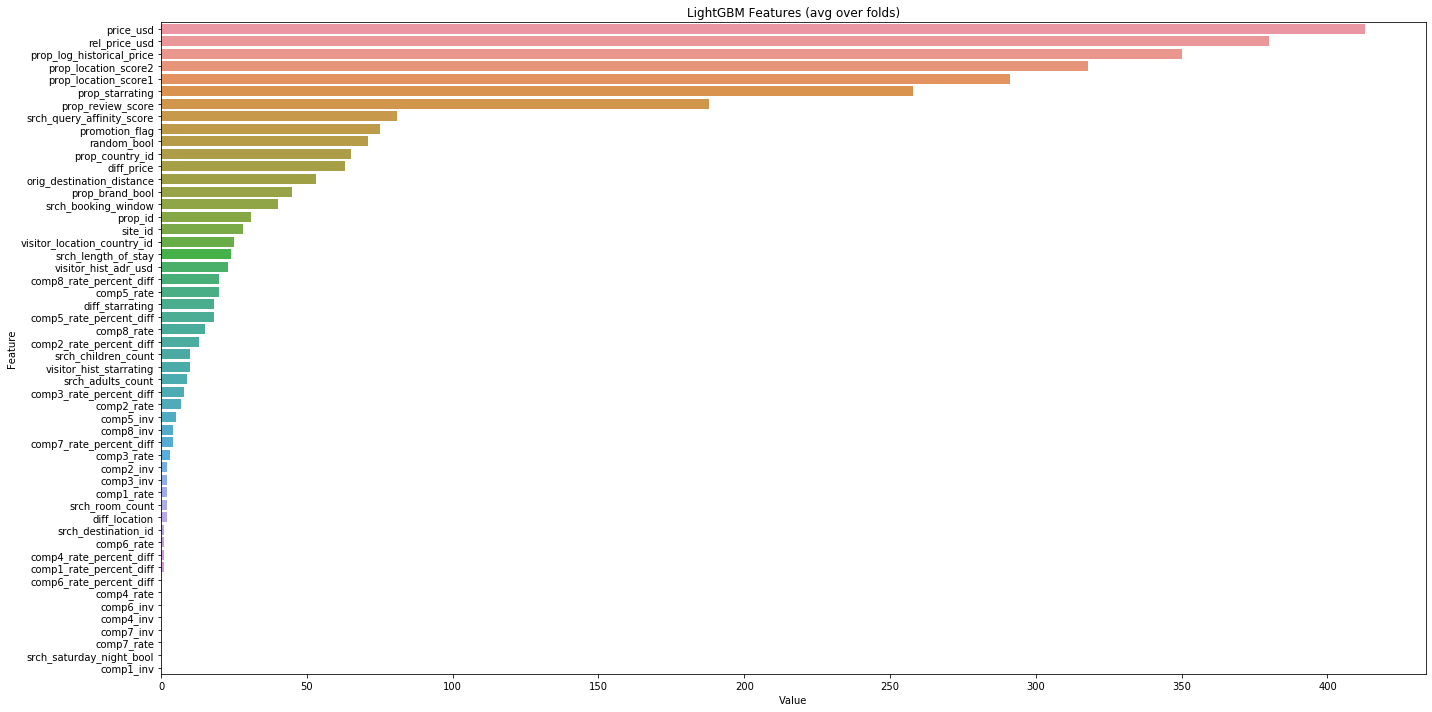

<Figure size 432x288 with 0 Axes>

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(m_lgbm.feature_importances_,colX)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()
plt.savefig('lgbm_importances-01.png')

## result

In [26]:
df_predictY = m_lgbm.predict(df_testX)
df_testY = df_testY.to_numpy(dtype = "int64")
result = ndcg_score(df_testY, df_predictY, group = group_test)
print(result)

0.40161961316875405


In [27]:
df_test.head(10)

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score1,prop_location_score2,prop_log_historical_price,price_usd,promotion_flag,srch_destination_id,srch_length_of_stay,srch_booking_window,srch_adults_count,srch_children_count,srch_room_count,srch_saturday_night_bool,srch_query_affinity_score,orig_destination_distance,random_bool,comp1_rate,comp1_inv,comp1_rate_percent_diff,comp2_rate,comp2_inv,comp2_rate_percent_diff,comp3_rate,comp3_inv,comp3_rate_percent_diff,comp4_rate,comp4_inv,comp4_rate_percent_diff,comp5_rate,comp5_inv,comp5_rate_percent_diff,comp6_rate,comp6_inv,comp6_rate_percent_diff,comp7_rate,comp7_inv,comp7_rate_percent_diff,comp8_rate,comp8_inv,comp8_rate_percent_diff,click_bool,booking_bool,diff_starrating,diff_price,diff_location,score,price_mean,rel_price_usd
211,25,2012-12-11 13:03:42,5,219,NaN,NaN,219,23228,4,4.0,0,3.26,0.3676,4.44,42.00,1,3735,1,0,2,0,1,0,NaN,767.86,0,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,1,1,NaN,NaN,3516,6,65.125000,-23.125000
219,25,2012-12-11 13:03:42,5,219,NaN,NaN,219,61885,3,3.5,1,1.79,0.0061,5.72,139.00,0,3735,1,0,2,0,1,0,NaN,766.02,0,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,0,NaN,NaN,3516,0,65.125000,73.875000
220,25,2012-12-11 13:03:42,5,219,NaN,NaN,219,63731,3,5.0,1,0.69,0.0005,5.27,119.00,0,3735,1,0,2,0,1,0,NaN,761.97,0,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,-1.0,0.0,16.0,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,0.0,16.0,0,0,NaN,NaN,3516,0,65.125000,53.875000
223,25,2012-12-11 13:03:42,5,219,NaN,NaN,219,66209,4,4.0,1,3.26,0.2481,4.17,32.00,1,3735,1,0,2,0,1,0,NaN,767.78,0,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,0,NaN,NaN,3516,0,65.125000,-33.125000
227,25,2012-12-11 13:03:42,5,219,NaN,NaN,219,81772,3,3.5,0,3.22,0.2775,4.16,29.00,0,3735,1,0,2,0,1,0,NaN,768.08,0,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,0,NaN,NaN,3516,0,65.125000,-36.125000
231,25,2012-12-11 13:03:42,5,219,NaN,NaN,219,112716,4,4.0,0,1.61,0.0512,4.42,48.00,0,3735,1,0,2,0,1,0,NaN,764.98,0,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,0,NaN,NaN,3516,0,65.125000,-17.125000
233,25,2012-12-11 13:03:42,5,219,NaN,NaN,219,120046,4,4.0,0,3.26,0.0955,4.68,50.00,0,3735,1,0,2,0,1,0,NaN,767.68,0,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,0,NaN,NaN,3516,0,65.125000,-15.125000
234,25,2012-12-11 13:03:42,5,219,NaN,NaN,219,120328,2,3.5,1,1.79,0.0061,4.52,62.00,0,3735,1,0,2,0,1,0,NaN,766.02,0,NaN,NaN,NaN,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,0,NaN,NaN,3516,0,65.125000,-3.125000
292,30,2013-02-11 01:28:38,24,216,NaN,NaN,219,14504,2,3.0,0,4.74,0.4578,5.05,120.61,0,20319,9,13,2,0,1,0,NaN,NaN,0,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,-1.0,0.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,0.0,6.0,0,0,NaN,NaN,20100,0,186.876667,-66.266667
301,30,2013-02-11 01:28:38,24,216,NaN,NaN,219,41585,4,4.0,1,4.60,0.3128,5.84,227.67,1,20319,9,13,2,0,1,0,NaN,NaN,0,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,0.0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,0,NaN,NaN,20100,0,186.876667,40.793333


# 6 Random Forest Classifier

In [29]:
df_sample.fillna(value = -999, inplace = True)

In [30]:
df_train = df_sample[df_sample['srch_id']%5 != 0]
df_test = df_sample[df_sample['srch_id']%5 == 0]
group_train = df_train.groupby('srch_id').size().reset_index(name='Size')['Size']
group_test = df_test.groupby('srch_id').size().reset_index(name='Size')['Size']
df_sample.columns
df_trainX = df_train[colX]
df_trainY = df_train[colY]
df_testX = df_test[colX]
df_testY = df_test[colY]

In [31]:
%%time
import sklearn.ensemble
m_rf = sklearn.ensemble.RandomForestClassifier(n_estimators = 100, min_samples_split = 1000)
m_rf.fit(df_trainX, df_trainY)

C:\Users\DELL\anaconda3\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


Wall time: 10min 55s


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=1000,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [32]:
df_predictY = m_rf.predict(df_testX)
df_testY = df_testY.to_numpy(dtype = "int64")
result = ndcg_score(df_testY, df_predictY, group = group_test)
print(result)

0.3704630764742695


# 7 Conclusion

LGBMRanker has better better performance(ndcg = 0.402 vs ndcg = 0.370), and less running time(25s vs 10 min) than Random Forest Model